In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Suppose these come from your methods folder
from methods.ebgan import EnergyModel as EBGAN_EnergyModel
from methods.ebgan import Generator as EBGAN_Generator
from methods.ebgan import train as train_ebgan_method
from methods.ebgan_mdn import train_ebgan_mdn
from methods.mdn import MDNGenerator, mdn_loss, train as train_mdn_method

# For reproducibility
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)

Using device: cpu


In [2]:
def generate_gaussians_on_grid(
    grid_size=5, 
    spacing=1.25,
    points_per_center=300,
    cov_scale=0.05,
):
    """
    Create a grid (grid_size x grid_size) of 2D Gaussian clusters.
    Returns the array of shape (grid_size^2 * points_per_center, 2)
    plus the cluster centers.
    """
    centers = []
    offset = (grid_size - 1)/2.0
    for i in range(grid_size):
        for j in range(grid_size):
            cx = (i - offset) * spacing
            cy = (j - offset) * spacing
            centers.append([cx, cy])
    centers = np.array(centers, dtype=np.float32)

    # Generate samples
    all_samples = []
    for center in centers:
        cov = np.eye(2)*cov_scale
        samples = np.random.multivariate_normal(center, cov, points_per_center)
        all_samples.append(samples)
    all_samples = np.vstack(all_samples).astype(np.float32)
    np.random.shuffle(all_samples)
    return all_samples, centers

# Generate your 2D dataset
X, centers = generate_gaussians_on_grid(
    grid_size=7,
    spacing=1.2,
    points_per_center=200,
    cov_scale=0.03
)

true_centers = centers  # store for coverage check

print("Data shape:", X.shape, "Number of clusters:", len(centers))

# Put data into a DataLoader
batch_size = 32
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
dummy_x = torch.zeros_like(X_tensor).to(device)
dataset = TensorDataset(dummy_x, X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Data shape: (9800, 2) Number of clusters: 49


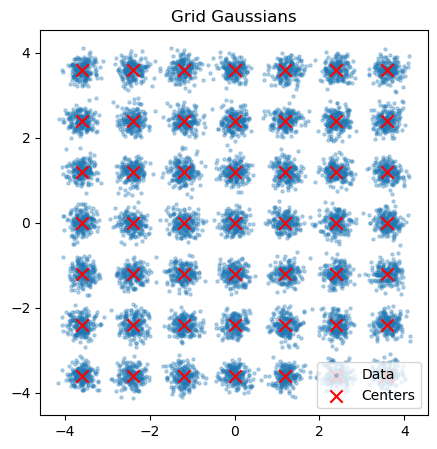

In [3]:
# Quick visualization
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=5, alpha=0.3, label="Data")
plt.scatter(centers[:,0], centers[:,1], c="red", marker="x", s=80, label="Centers")
plt.axis("equal")
plt.legend()
plt.title("Grid Gaussians")
plt.show()

In [4]:
ebgan_gen = EBGAN_Generator(
    latent_size=1,
    hidden_size=64,     
    action_size=2,
    condition_size=2
).to(device)

ebgan_energy = EBGAN_EnergyModel(
    input_size=2,       # maps (x=2D) to energy
    action_size=2,
    hidden_size=64
).to(device)

# Optimizers with shapes-like LRs:
opt_e_eb = optim.Adam(ebgan_energy.parameters(), lr=1e-3)  
opt_g_eb = optim.Adam(ebgan_gen.parameters(), lr=5e-4)
scheduler_e_eb = optim.lr_scheduler.StepLR(opt_e_eb, step_size=20, gamma=0.5)
scheduler_g_eb = optim.lr_scheduler.StepLR(opt_g_eb, step_size=20, gamma=0.5)

y_min = torch.tensor([-5.0, -5.0]).to(device)
y_max = torch.tensor([ 5.0,  5.0]).to(device)

num_epochs_ebgan = 50
neg_count = 32
repeat_energy_updates = 5

train_ebgan_method(
    dataloader,
    ebgan_gen,
    ebgan_energy,
    opt_g_eb,
    opt_e_eb,
    scheduler_e_eb,
    scheduler_g_eb,
    num_epochs_ebgan,
    writer=None,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device
)

Epoch [1/50], Energy Loss: 3.3678, Generator Loss: 1.5837
Epoch [2/50], Energy Loss: 3.1657, Generator Loss: 1.8636
Epoch [3/50], Energy Loss: 3.1238, Generator Loss: 1.1773
Epoch [4/50], Energy Loss: 3.1041, Generator Loss: 1.2760
Epoch [5/50], Energy Loss: 3.0955, Generator Loss: 1.3702
Epoch [6/50], Energy Loss: 3.0857, Generator Loss: 1.4854
Epoch [7/50], Energy Loss: 3.0728, Generator Loss: 1.4789
Epoch [8/50], Energy Loss: 3.0661, Generator Loss: 1.8520
Epoch [9/50], Energy Loss: 3.0602, Generator Loss: 2.0153
Epoch [10/50], Energy Loss: 3.0544, Generator Loss: 2.2028
Epoch [11/50], Energy Loss: 3.0492, Generator Loss: 2.0611
Epoch [12/50], Energy Loss: 3.0459, Generator Loss: 2.1985
Epoch [13/50], Energy Loss: 3.0391, Generator Loss: 2.3913
Epoch [14/50], Energy Loss: 3.0355, Generator Loss: 2.5546
Epoch [15/50], Energy Loss: 3.0258, Generator Loss: 2.8954
Epoch [16/50], Energy Loss: 3.0098, Generator Loss: 3.3341
Epoch [17/50], Energy Loss: 2.9975, Generator Loss: 3.8894
Epoch 

In [5]:
def sample_ebgan(model, n_samples=1000):
    """
    model: EBGAN_Generator
    Returns (n_samples, 2) of generated points on CPU.
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_size).to(device)
        # For unconditional setup, we can pass x_input = 0D or None. 
        # If the generator expects condition, be sure to pass a matching shape (like zeros).
        # But if your EBGAN generator is unconditional for 2D, we do:
        condition = torch.zeros(n_samples, 2).to(device)  # empty if condition_size=0
        gen_xy = model(z, condition)  # shape (n_samples, 2)
    return gen_xy.cpu()

In [6]:
def visualize_generated(
    model_name,
    sample_fn,
    model,
    real_data,
    real_centers,
    n_samples=2000,
    energy_model=None,  # optional: pass in the energy model
    device="cpu",
    xlim=(-5, 5),
    ylim=(-5, 5),
    grid_size=100
):
    """
    Visualize real data, generated samples, cluster centers,
    and optionally the energy model's landscape.

    Args:
        model_name (str): A string identifier for the model name (for the title).
        sample_fn (callable): A function(model, n_samples) -> (n_samples, 2) for generating samples.
        model: The generator model (e.g., EBGAN_Generator or MDNGenerator).
        real_data (np.ndarray): Array of real data points, shape (N, 2).
        real_centers (np.ndarray): Array of cluster centers, shape (M, 2).
        n_samples (int): How many points to generate for plotting.
        energy_model (nn.Module, optional): If provided, will use it to plot the energy landscape.
        device (str): "cpu" or "cuda".
        xlim (tuple): (x_min, x_max) range for the plot.
        ylim (tuple): (y_min, y_max) range for the plot.
        grid_size (int): Resolution of the energy grid.
    """
    # 1) Generate synthetic samples
    gen_data = sample_fn(model, n_samples).cpu().numpy()

    # 2) Plot energy landscape if energy_model is provided
    if energy_model is not None:
        # Create a meshgrid over [xlim, ylim]
        x_vals = np.linspace(xlim[0], xlim[1], grid_size)
        y_vals = np.linspace(ylim[0], ylim[1], grid_size)
        X_grid, Y_grid = np.meshgrid(x_vals, y_vals)

        # Convert grid to Torch tensors on the correct device
        X_tensor = torch.tensor(X_grid.ravel(), dtype=torch.float32, device=device).unsqueeze(1)
        Y_tensor = torch.tensor(Y_grid.ravel(), dtype=torch.float32, device=device).unsqueeze(1)

        # Concatenate condition and action for the energy model
        energy_input = torch.cat([X_tensor, Y_tensor], dim=1)  # Shape: (grid_size * grid_size, 4)

        # Forward pass through the energy model
        with torch.no_grad():
            energy_values = energy_model(energy_input, energy_input).cpu().numpy().reshape(grid_size, grid_size)

        # Plot the heatmap or contour
        plt.figure(figsize=(6, 6))
        plt.imshow(energy_values, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), origin='lower', cmap='coolwarm', alpha=0.5)
    else:
        # No energy landscape, just make a new figure
        plt.figure(figsize=(6, 6))

    # 3) Plot real data, generated samples, and centers
    plt.scatter(
        real_data[:, 0], 
        real_data[:, 1], 
        s=5, alpha=0.3, 
        label="Real data", 
        color="blue"
    )
    plt.scatter(
        gen_data[:, 0], 
        gen_data[:, 1], 
        s=5, alpha=0.3, 
        color="red", 
        label="Generated"
    )
    plt.scatter(
        real_centers[:, 0], 
        real_centers[:, 1], 
        marker='x', 
        color='green', 
        s=80, 
        label="Centers"
    )

    # 4) Final plot settings
    plt.title(f"{model_name} Predictions vs. Real Data")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axis("equal")
    plt.legend()
    plt.show()

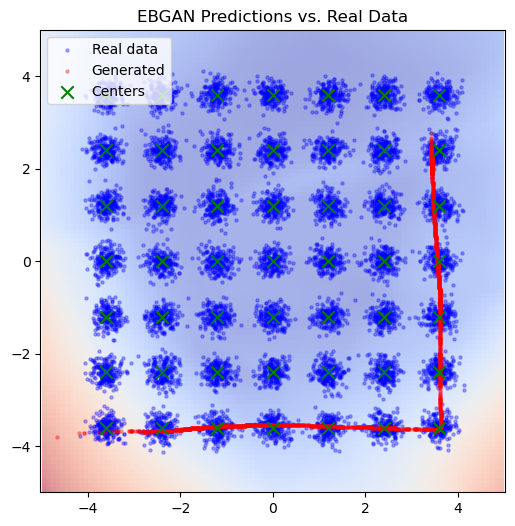

In [7]:
# Visualize with energy landscape
visualize_generated(
    model_name="EBGAN",
    sample_fn=sample_ebgan,
    model=ebgan_gen,
    real_data=X,           # Replace with your real data points
    real_centers=centers,  # Replace with your cluster centers
    n_samples=2000,
    energy_model=ebgan_energy,  # Pass the trained energy model
    device=device,
    xlim=(-5, 5),  # Adjust as per your dataset
    ylim=(-5, 5),  # Adjust as per your dataset
    grid_size=100  # Resolution of the energy landscape
)

Epoch [1/50], Energy Loss: 3.3247, Generator Loss: 3.7917, Generator Energy Loss: 0.6859, Generator MDN Loss: 3.1057
Epoch [2/50], Energy Loss: 3.1422, Generator Loss: 2.2423, Generator Energy Loss: -0.7293, Generator MDN Loss: 2.9716
Epoch [3/50], Energy Loss: 3.1214, Generator Loss: -0.1421, Generator Energy Loss: -2.9812, Generator MDN Loss: 2.8390
Epoch [4/50], Energy Loss: 3.1008, Generator Loss: -3.3700, Generator Energy Loss: -6.0872, Generator MDN Loss: 2.7172
Epoch [5/50], Energy Loss: 3.0725, Generator Loss: -8.6046, Generator Energy Loss: -11.1884, Generator MDN Loss: 2.5839
Epoch [6/50], Energy Loss: 3.0531, Generator Loss: -15.1486, Generator Energy Loss: -17.6808, Generator MDN Loss: 2.5323
Epoch [7/50], Energy Loss: 3.0307, Generator Loss: -20.5281, Generator Energy Loss: -23.0439, Generator MDN Loss: 2.5158
Epoch [8/50], Energy Loss: 3.0214, Generator Loss: -25.8108, Generator Energy Loss: -28.2631, Generator MDN Loss: 2.4522
Epoch [9/50], Energy Loss: 3.0146, Generator

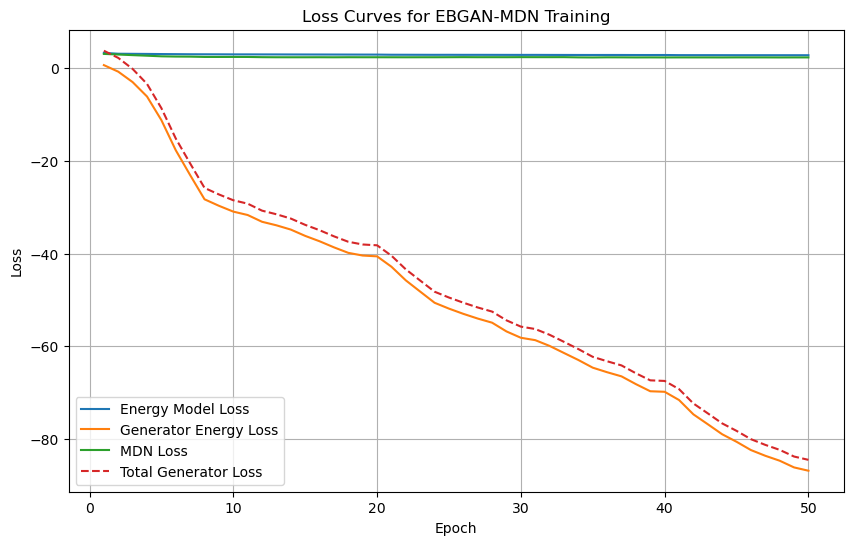

In [8]:
# In EBGAN_MDN.py, we have train_ebgan_mdn(...) that 
# uses an EnergyModel + MDNGenerator. We just define a sampler:

def sample_ebgan_mdn(model, n_samples=1000):
    """
    model: MDNGenerator in the EBGAN-MDN context (with sample(...))
    """
    model.eval()
    with torch.no_grad():
        # We feed random latent z and condition=0 if unconditional
        z = torch.randn(n_samples, model.latent_size).to(device)
        condition = torch.zeros(n_samples, 2).to(device)  # no condition
        gen_xy = model.sample(z, condition)  # shape (n_samples, 2)
    return gen_xy.cpu()

from methods.ebgan import EnergyModel as EBM_MDN_Energy

ebgan_mdn_generator = MDNGenerator(
    input_size=1,
    hidden_size=64,
    output_size=2,
    num_gaussians=10,
    condition_size=2
).to(device)

ebgan_mdn_energy = EBM_MDN_Energy(
    input_size=2,
    action_size=2,
    hidden_size=64
).to(device)

opt_e_emd = optim.Adam(ebgan_mdn_energy.parameters(), lr=1e-3)
opt_g_emd = optim.Adam(ebgan_mdn_generator.parameters(), lr=5e-4)
sched_e_emd = optim.lr_scheduler.StepLR(opt_e_emd, step_size=20, gamma=0.5)
sched_g_emd = optim.lr_scheduler.StepLR(opt_g_emd, step_size=20, gamma=0.5)

num_epochs_ebgan_mdn = 50
alpha=1
dynamic_scaling_true=True
min_scale=0.1

train_ebgan_mdn(
    dataloader=dataloader,
    energy_model=ebgan_mdn_energy,
    generator=ebgan_mdn_generator,
    optimizer_e=opt_e_emd,
    optimizer_g=opt_g_emd,
    scheduler_e=sched_e_emd,
    scheduler_g=sched_g_emd,
    num_epochs=num_epochs_ebgan_mdn,
    writer=None,
    y_min=y_min,
    y_max=y_max,
    neg_count=32,
    repeat_energy_updates=5,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,  
    min_scale=min_scale
)

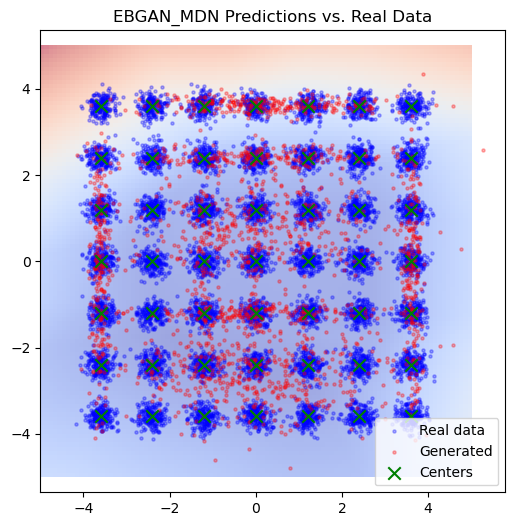

In [9]:
# Visualize with energy landscape
visualize_generated(
    model_name="EBGAN_MDN",
    sample_fn=sample_ebgan_mdn,
    model=ebgan_mdn_generator,
    real_data=X,           # Replace with your real data points
    real_centers=centers,  # Replace with your cluster centers
    n_samples=2000,
    energy_model=ebgan_mdn_energy,  # Pass the trained energy model
    device=device,
    xlim=(-5, 5),  # Adjust as per your dataset
    ylim=(-5, 5),  # Adjust as per your dataset
    grid_size=100  # Resolution of the energy landscape
)

In [10]:
# In MDN.py, we have MDNGenerator plus train(...). We define a sampler:
def sample_mdn(model, n_samples=1000):
    """
    model: MDNGenerator
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_size).to(device)
        condition = torch.zeros(n_samples, 2).to(device)  # no condition
        xy = model.sample(z, condition)  # shape (n_samples, 2)
    return xy.cpu()

mdn_model = MDNGenerator(
    input_size=1,
    hidden_size=64,
    output_size=2,
    num_gaussians=10,    # or keep 7/14 if you prefer; but we’ll set 10 for consistency
    condition_size=2
).to(device)

opt_mdn = optim.Adam(mdn_model.parameters(), lr=5e-4)
sched_mdn = optim.lr_scheduler.StepLR(opt_mdn, step_size=20, gamma=0.5)

num_epochs_mdn = 50

train_mdn_method(
    mdn_model, 
    dataloader, 
    mdn_loss, 
    opt_mdn, 
    sched_mdn, 
    num_epochs_mdn, 
    writer=None, 
    device=device
)

Epoch [1/50], Loss: 2.9894, LR: 0.000500
Epoch [2/50], Loss: 2.7599, LR: 0.000500
Epoch [3/50], Loss: 2.7419, LR: 0.000500
Epoch [4/50], Loss: 2.6640, LR: 0.000500
Epoch [5/50], Loss: 2.5916, LR: 0.000500
Epoch [6/50], Loss: 2.5446, LR: 0.000500
Epoch [7/50], Loss: 2.5132, LR: 0.000500
Epoch [8/50], Loss: 2.4206, LR: 0.000500
Epoch [9/50], Loss: 2.3913, LR: 0.000500
Epoch [10/50], Loss: 2.3165, LR: 0.000500
Epoch [11/50], Loss: 2.3079, LR: 0.000500
Epoch [12/50], Loss: 2.3052, LR: 0.000500
Epoch [13/50], Loss: 2.3086, LR: 0.000500
Epoch [14/50], Loss: 2.3085, LR: 0.000500
Epoch [15/50], Loss: 2.3075, LR: 0.000500
Epoch [16/50], Loss: 2.3069, LR: 0.000500
Epoch [17/50], Loss: 2.3052, LR: 0.000500
Epoch [18/50], Loss: 2.3050, LR: 0.000500
Epoch [19/50], Loss: 2.3077, LR: 0.000500
Epoch [20/50], Loss: 2.3087, LR: 0.000250
Epoch [21/50], Loss: 2.2992, LR: 0.000250
Epoch [22/50], Loss: 2.2954, LR: 0.000250
Epoch [23/50], Loss: 2.2974, LR: 0.000250
Epoch [24/50], Loss: 2.2989, LR: 0.000250
E

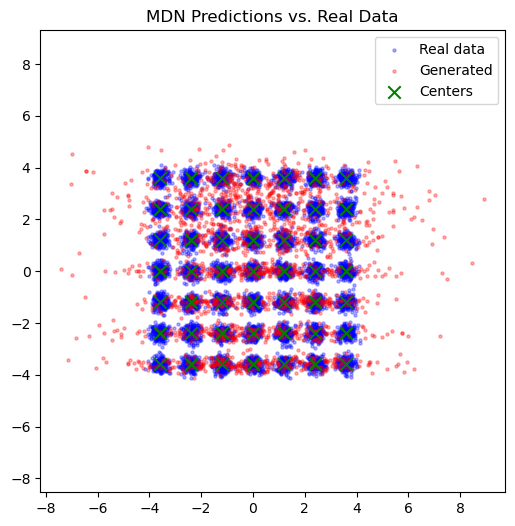

In [11]:
# Visualize with energy landscape
visualize_generated(
    model_name="MDN",
    sample_fn=sample_mdn,
    model=mdn_model,
    real_data=X,           # Replace with your real data points
    real_centers=centers,  # Replace with your cluster centers
    n_samples=2000,
    energy_model=None,
    device=device,
    xlim=(-5, 5),  # Adjust as per your dataset
    ylim=(-5, 5),  # Adjust as per your dataset
    grid_size=100  # Resolution of the energy landscape
)

In [12]:
from scipy.stats import entropy, wasserstein_distance

def compute_metrics(
    sample_fn,       # function(model, n_samples) -> (n_samples, 2) points
    model,
    real_data,       # (N, 2)
    real_centers,    # (#centers, 2)
    n_gen_samples=5000,
    coverage_tol=0.15,
    num_bins=50,
):
    # Generate samples
    gen_samples = sample_fn(model, n_gen_samples)
    gen_samples = gen_samples.cpu().numpy()  # shape (n_gen_samples, 2)

    # 1) Mode coverage
    coverage_count = 0
    for center in real_centers:
        dists = np.linalg.norm(gen_samples - center, axis=1)
        if np.any(dists < coverage_tol):
            coverage_count += 1
    coverage_pct = coverage_count / len(real_centers)*100

    # 2) 2D histogram comparison
    real_hist, xedges, yedges = np.histogram2d(
        real_data[:,0], real_data[:,1], 
        bins=num_bins, density=True
    )
    gen_hist, _, _ = np.histogram2d(
        gen_samples[:,0], gen_samples[:,1], 
        bins=[xedges, yedges], density=True
    )

    # Avoid zeros
    real_hist += 1e-8
    gen_hist += 1e-8

    # Flatten
    real_hist_flat = real_hist.ravel()
    gen_hist_flat = gen_hist.ravel()

    # Normalize
    real_hist_flat /= real_hist_flat.sum()
    gen_hist_flat /= gen_hist_flat.sum()

    # KL
    kl_div = entropy(real_hist_flat, gen_hist_flat)
    # Wasserstein
    w_dist = wasserstein_distance(real_hist_flat, gen_hist_flat)

    return {
        "Mode Coverage(%)": coverage_pct,
        "KL Divergence": kl_div,
        "Wasserstein Distance": w_dist
    }

In [13]:
metrics_ebgan = compute_metrics(
    sample_ebgan,
    ebgan_gen,
    real_data=X,
    real_centers=true_centers,
    n_gen_samples=3000,
    coverage_tol=0.075,
    num_bins=50
)
print("EBGAN metrics:", metrics_ebgan)

EBGAN metrics: {'Mode Coverage(%)': 16.3265306122449, 'KL Divergence': np.float64(13.803450487026819), 'Wasserstein Distance': np.float64(0.0006173904972829921)}


In [14]:
metrics_mdn_ = compute_metrics(
    sample_mdn,
    mdn_model,
    real_data=X,
    real_centers=true_centers,
    n_gen_samples=3000,
    coverage_tol=0.075,
    num_bins=50
)
print("Plain MDN metrics:", metrics_mdn_)

Plain MDN metrics: {'Mode Coverage(%)': 63.26530612244898, 'KL Divergence': np.float64(4.630774602979287), 'Wasserstein Distance': np.float64(0.00013439075476062527)}


In [15]:
metrics_ebgan_mdn = compute_metrics(
    sample_ebgan_mdn,
    ebgan_mdn_generator,
    real_data=X,
    real_centers=true_centers,
    n_gen_samples=3000,
    coverage_tol=0.075,
    num_bins=50
)
print("EBGAN-MDN metrics:", metrics_ebgan_mdn)

EBGAN-MDN metrics: {'Mode Coverage(%)': 75.51020408163265, 'KL Divergence': np.float64(5.107199321766977), 'Wasserstein Distance': np.float64(9.812691898360886e-05)}


In [16]:
# Function to aggregate metrics
def aggregate_metrics(metrics_list):
    keys = metrics_list[0].keys()
    aggregated = {}
    for key in keys:
        aggregated[key] = np.mean([metrics[key] for metrics in metrics_list])
    return aggregated

In [20]:
# Function to run training multiple times and compute average metrics
def run_multiple_training_runs(
    model_name, train_fn, sample_fn, init_fn, real_data, real_centers, 
    dataloader, compute_metrics_fn, n_runs=5, **train_kwargs
):
    all_metrics = []
    for run in range(n_runs):
        print(f"Training {model_name} - Run {run + 1}/{n_runs}")

        # Initialize models and optimizers
        models, optimizers, schedulers = init_fn()

        # Train the model
        train_fn(
            dataloader=dataloader,
            **models,
            **optimizers,
            **schedulers,
            **train_kwargs
        )

        # Compute metrics
        metrics = compute_metrics_fn(
            sample_fn,
            models["generator"],
            real_data,
            real_centers,
            n_gen_samples=3000,
            coverage_tol=0.075,
            num_bins=50
        )
        print(f"Run {run + 1} Metrics: {metrics}")
        all_metrics.append(metrics)

        # Visualize results
        visualize_generated(
            model_name=f"{model_name} Run {run + 1}",
            sample_fn=sample_fn,
            model=models["generator"],
            real_data=real_data,
            real_centers=real_centers,
            n_samples=2000,
            energy_model=models.get("energy_model"),
            device=device,
            xlim=(-5, 5),
            ylim=(-5, 5),
            grid_size=100
        )

    # Aggregate metrics
    avg_metrics = aggregate_metrics(all_metrics)
    print(f"Average Metrics for {model_name}: {avg_metrics}")
    return avg_metrics

In [21]:
# Define initialization functions for models, optimizers, and schedulers
def init_ebgan():
    generator = EBGAN_Generator(
        latent_size=1,
        hidden_size=64,
        action_size=2,
        condition_size=2
    ).to(device)

    energy_model = EBGAN_EnergyModel(
        input_size=2,
        action_size=2,
        hidden_size=64
    ).to(device)

    optimizer_e = optim.Adam(energy_model.parameters(), lr=1e-3)
    optimizer_g = optim.Adam(generator.parameters(), lr=5e-4)

    scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=20, gamma=0.5)

    return {"generator": generator, "energy_model": energy_model}, {"optimizer_g": optimizer_g, "optimizer_e": optimizer_e}, {"scheduler_g": scheduler_g, "scheduler_e": scheduler_e}

def init_ebgan_mdn():
    generator = MDNGenerator(
        input_size=1,
        hidden_size=64,
        output_size=2,
        num_gaussians=10,
        condition_size=2
    ).to(device)

    energy_model = EBGAN_EnergyModel(
        input_size=2,
        action_size=2,
        hidden_size=64
    ).to(device)

    optimizer_e = optim.Adam(energy_model.parameters(), lr=1e-3)
    optimizer_g = optim.Adam(generator.parameters(), lr=5e-4)

    scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=20, gamma=0.5)

    return {"generator": generator, "energy_model": energy_model}, {"optimizer_g": optimizer_g, "optimizer_e": optimizer_e}, {"scheduler_g": scheduler_g, "scheduler_e": scheduler_e}

def init_mdn():
    generator = MDNGenerator(
        input_size=1,
        hidden_size=64,
        output_size=2,
        num_gaussians=10,
        condition_size=2
    ).to(device)

    optimizer_g = optim.Adam(generator.parameters(), lr=5e-4)
    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=20, gamma=0.5)

    return {"generator": generator}, {"optimizer_g": optimizer_g}, {"scheduler_g": scheduler_g}

In [22]:
# Run multiple training runs and compute average metrics
avg_metrics_ebgan = run_multiple_training_runs(
    model_name="EBGAN",
    train_fn=train_ebgan_method,
    sample_fn=sample_ebgan,
    init_fn=init_ebgan,
    real_data=X,
    real_centers=centers,
    dataloader=dataloader,
    compute_metrics_fn=compute_metrics,
    n_runs=5,
    num_epochs=50,
    writer=None,
    y_min=y_min,
    y_max=y_max,
    neg_count=32,
    repeat_energy_updates=5,
    device=device
)

# Repeat for EBGAN-MDN and MDN
avg_metrics_ebgan_mdn = run_multiple_training_runs(
    model_name="EBGAN-MDN",
    train_fn=train_ebgan_mdn,
    sample_fn=sample_ebgan_mdn,
    init_fn=init_ebgan_mdn,
    real_data=X,
    real_centers=centers,
    dataloader=dataloader,
    compute_metrics_fn=compute_metrics,
    n_runs=5,
    num_epochs=50,
    writer=None,
    y_min=y_min,
    y_max=y_max,
    neg_count=32,
    repeat_energy_updates=5,
    device=device
)

avg_metrics_mdn = run_multiple_training_runs(
    model_name="MDN",
    train_fn=train_mdn_method,
    sample_fn=sample_mdn,
    init_fn=init_mdn,
    real_data=X,
    real_centers=centers,
    dataloader=dataloader,
    compute_metrics_fn=compute_metrics,
    n_runs=5,
    num_epochs=50,
    writer=None,
    device=device
)

Training EBGAN - Run 1/5
Epoch [1/50], Energy Loss: 3.3533, Generator Loss: 1.5718
Epoch [2/50], Energy Loss: 3.1643, Generator Loss: 1.9592
Epoch [3/50], Energy Loss: 3.1100, Generator Loss: 1.4667
Epoch [4/50], Energy Loss: 3.0909, Generator Loss: 1.2644
Epoch [5/50], Energy Loss: 3.0757, Generator Loss: 1.2825
Epoch [6/50], Energy Loss: 3.0597, Generator Loss: 1.3332
Epoch [7/50], Energy Loss: 3.0477, Generator Loss: 1.2891
Epoch [8/50], Energy Loss: 3.0211, Generator Loss: 1.3528
Epoch [9/50], Energy Loss: 3.0129, Generator Loss: 1.2633
Epoch [10/50], Energy Loss: 2.9908, Generator Loss: 1.3380
Epoch [11/50], Energy Loss: 2.9822, Generator Loss: 1.3031
Epoch [12/50], Energy Loss: 2.9655, Generator Loss: 1.1700
Epoch [13/50], Energy Loss: 2.9498, Generator Loss: 1.2740
Epoch [14/50], Energy Loss: 2.9415, Generator Loss: 1.5012
Epoch [15/50], Energy Loss: 2.9296, Generator Loss: 1.3120
Epoch [16/50], Energy Loss: 2.9194, Generator Loss: 1.2369
Epoch [17/50], Energy Loss: 2.9115, Gene

KeyboardInterrupt: 